In [26]:
# Libraries
import gpflow
import os
import pandas as pd
import pickle
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from waveome.kernels import Lin
from waveome.model_search import GPSearch

## Data Preparation

In [27]:
# Data Read
mbx = pd.read_csv('../iHMP/data/iHMP_labeled_metabolomics.csv', low_memory=False)
mtd = pd.read_csv('../iHMP/data/iHMP_metadata.csv', low_memory=False)

# Clean up
# Save separate lookup table
mbx_lookup = mbx[['HMDB (*Representative ID)', 'Metabolite', 'Compound']]
mbx = (
    mbx
    # Drop all column identifiers that aren't necessary for search
    .drop(columns=mbx.columns[:6])
    # Prepare to transpose dataframe
    .set_index('Compound')
    # Make sure we have observation (row) by metabolite (column)
    .transpose()
    # Pull off index for matching
    .reset_index(names='External ID')
    # Impute zero for missing intensity value
    .fillna(0.)
    .set_index('External ID')
    .sort_index()
)

# Filter to metabolites that have a non-zero median
mbx_lookup = mbx_lookup.loc[(mbx.quantile(q=0.5, axis=0) > 0).values, :]
mbx = mbx.loc[:, (mbx.quantile(q=0.5, axis=0) > 0).values]

mbx

Compound,C18n_QI06,C18n_QI07,C18n_QI08,C18n_QI10,C18n_QI11,C18n_TF1,C18n_QI12,C18n_QI13,C18n_QI14,C18n_TF2,...,HILp_QI13155,HILp_TF17,HILp_TF35,HILp_TF19,HILp_QI25304,HILp_TF2,HILp_TF3,HILp_TF12,HILp_QI23736,HILp_QI24373
External ID,,,,,,,,,,,,,,,,,,,,,
CSM5FZ3N,942546.0,1418451.0,2194.0,38180.0,5893.0,0.0,4174.0,211440.0,15667.0,376297.0,...,19777461.0,9997928.0,3579319.0,2066660.0,86595.0,274385476.0,136360623.0,2.119068e+08,36328.0,586321.0
CSM5FZ3T,470132.0,416924.0,28.0,11781.0,6345.0,0.0,5257.0,29713.0,2833.0,0.0,...,34863534.0,69914375.0,6996249.0,15657037.0,1162223.0,70872089.0,5868952.0,3.456104e+09,119223.0,3284388.0
CSM5FZ44,720369.0,1198835.0,436.0,8721.0,14372.0,0.0,5462.0,86293.0,64553.0,1010264.0,...,15526303.0,12300553.0,1812524.0,7134468.0,95476.0,90077297.0,10050253.0,9.373580e+08,0.0,323194.0
CSM5FZ48,1069292.0,1256069.0,773.0,62098.0,5653.0,0.0,3628.0,9523.0,18466.0,297950.0,...,14346185.0,14010937.0,4867731.0,17058734.0,0.0,250558333.0,238294493.0,3.669375e+08,36710.0,885943.0
CSM5FZ4A,1265301.0,1368667.0,542.0,3235743.0,10058.0,0.0,5165.0,25482.0,9282.0,484960.0,...,32308733.0,11756268.0,4435431.0,5256579.0,80735.0,6695543.0,872027.0,5.998712e+08,13503.0,1555485.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PSMA26A3,380042.0,320397.0,1008.0,108669.0,11948.0,499437.0,3172.0,10599.0,12693.0,397747.0,...,3250546.0,5144501.0,1554451.0,197869363.0,0.0,34836268.0,22973938.0,3.254163e+09,13148.0,2717657.0
PSMA26AJ,2930386.0,2661474.0,178.0,22508.0,4892.0,0.0,2441.0,42024.0,7902.0,530644.0,...,7154808.0,9858268.0,0.0,11257588.0,2302.0,145032134.0,80538278.0,6.841049e+08,0.0,231075.0
PSMB4MBK,494213.0,634210.0,193.0,24374.0,4879.0,0.0,4165.0,198330.0,10425.0,419596.0,...,10419020.0,8170396.0,931220.0,6057583.0,0.0,10612065.0,6931891.0,1.519354e+09,0.0,191390.0


In [28]:
# Subset and prep metadata informatin for each sample
column_list = [
    'External ID', 'Participant ID', 'site_name', 'Age at diagnosis',
    'consent_age', 'diagnosis', 'General wellbeing', 
    'hbi', 'date_of_receipt', 'race', 
    'General well being over the past 24 hours', 'sex',
]

# Map general wellbeing
wellbeing_map = {
    "Very Well": "very well",
    "Slightly below par": "below par",
    "Poor": "poor",
    "Very Poor": "very poor",
    "Terrible": "very poor"
}

mtd_sub = (
    mtd
    .loc[mtd['data_type'].values == 'metabolomics', column_list]
    .query("diagnosis == 'CD'")
    .rename(columns={
        'Participant ID': 'participant_id',
        'Age at diagnosis': 'age_at_diagnosis',
    })
    .assign(study_days = lambda x: (
        pd.to_datetime(x['date_of_receipt']) 
        - pd.to_datetime(x['date_of_receipt']).min()
        ).dt.days.astype("float")
    )
    .assign(min_id_study_days = lambda x: x.groupby("participant_id")["study_days"].transform('min'))
    .assign(age = lambda x: x['consent_age'] + ((x['study_days'] - x['min_id_study_days'])/365.))
    .assign(general_wellbeing = lambda x: x['General wellbeing'].combine_first(
        x['General well being over the past 24 hours'])
    )
    .assign(disease_state = lambda x: np.where(
        x['hbi'].between(0, 4),
        'Remission',
        np.where(
            x['hbi'].between(5, 7),
            'Mild',
            np.where(
                x['hbi'].between(8, 16),
                'Moderate',
                np.where(
                    x['hbi'] > 16,
                    'Severe',
                    'Unknown'
                )
            )
        )
        # source: https://www.researchgate.net/figure/Mayo-Score-and-Harvey-Bradshaw-index-classification_tbl1_336850204
    ))
    .drop(columns=[
        'General wellbeing',
        'General well being over the past 24 hours',
        'date_of_receipt',
        'min_id_study_days',
        'diagnosis',
        'consent_age',
        'age_at_diagnosis',
        'disease_state'
    ])
    .dropna()
    .set_index('External ID')
    .sort_index()
)

mtd_sub["general_wellbeing"] = mtd_sub.general_wellbeing.map(wellbeing_map)

# Add time around max event per individual
max_id_info = mtd_sub.groupby("participant_id").hbi.idxmax()
mtd_sub["time_from_max"] = (
    mtd_sub.study_days.values
    - mtd_sub.loc[max_id_info[mtd_sub["participant_id"]], "study_days"].values
)

mtd_sub

,participant_id,site_name,hbi,race,sex,study_days,age,general_wellbeing,time_from_max
External ID,,,,,,,,,
CSM5FZ3N,C3001,Cedars-Sinai,4.0,White,Female,93.0,43.000000,below par,-271.0
CSM5FZ3T,C3002,Cedars-Sinai,9.0,White,Female,139.0,76.000000,poor,0.0
CSM5FZ44,C3002,Cedars-Sinai,7.0,White,Female,195.0,76.153425,below par,56.0
CSM5FZ4C,C3001,Cedars-Sinai,3.0,White,Female,149.0,43.153425,very well,-215.0
CSM5MCU4,C3008,Cedars-Sinai,0.0,White,Female,202.0,53.000000,very well,-49.0
...,...,...,...,...,...,...,...,...,...
PSMA267B,P6033,MGH Pediatrics,1.0,White,Male,797.0,15.630137,very well,230.0
PSMA269E,P6028,MGH Pediatrics,0.0,White,Male,867.0,9.958904,very well,350.0
PSMA269I,P6037,MGH Pediatrics,2.0,White,Male,826.0,15.290411,below par,0.0


In [29]:
# Number of observations per individual check
median_obs_count = mtd_sub.groupby("participant_id").size().median()
print(f"Median number of observations per individual: {median_obs_count}")

Median number of observations per individual: 5.0


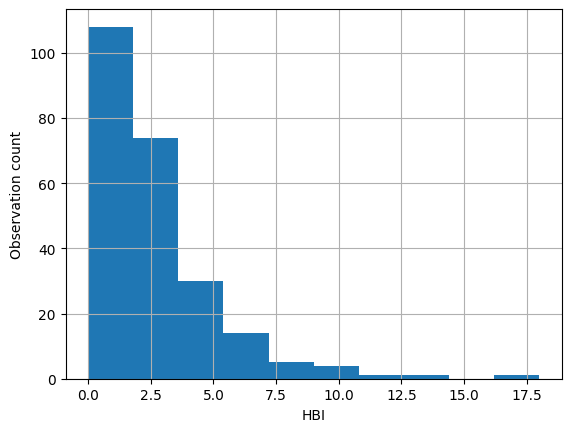

In [30]:
# Take a look at the main X variable of interest (HBI)
mtd_sub.hbi.hist()
plt.xlabel("HBI")
plt.ylabel("Observation count")
plt.show()

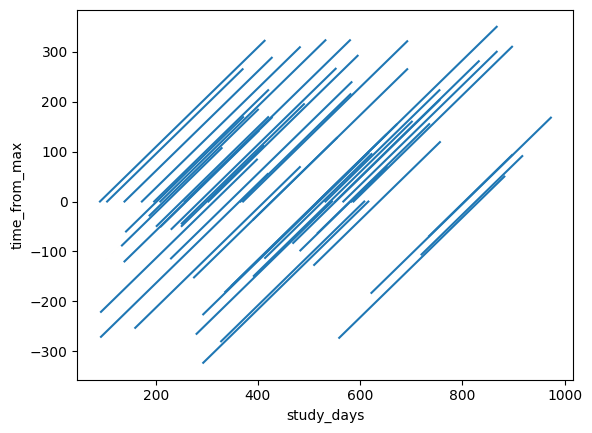

In [31]:
# Also demonstrate that time around max HBI point lies across calendar time dimension
sns.lineplot(
    data=mtd_sub,
    x="study_days",
    y="time_from_max",
    units="participant_id",
    estimator=None
)
plt.show()

In [32]:
# Also subset metabolite intensities to the subset of metadata
mbx_sub = mbx.loc[mbx.index.intersection(mtd_sub.index)]

# Check to make sure the indexes are the same
assert mtd_sub.index.equals(mbx_sub.index)

mbx_sub

Compound,C18n_QI06,C18n_QI07,C18n_QI08,C18n_QI10,C18n_QI11,C18n_TF1,C18n_QI12,C18n_QI13,C18n_QI14,C18n_TF2,...,HILp_QI13155,HILp_TF17,HILp_TF35,HILp_TF19,HILp_QI25304,HILp_TF2,HILp_TF3,HILp_TF12,HILp_QI23736,HILp_QI24373
External ID,,,,,,,,,,,,,,,,,,,,,
CSM5FZ3N,942546.0,1418451.0,2194.0,38180.0,5893.0,0.0,4174.0,211440.0,15667.0,376297.0,...,19777461.0,9997928.0,3579319.0,2066660.0,86595.0,274385476.0,136360623.0,2.119068e+08,36328.0,586321.0
CSM5FZ3T,470132.0,416924.0,28.0,11781.0,6345.0,0.0,5257.0,29713.0,2833.0,0.0,...,34863534.0,69914375.0,6996249.0,15657037.0,1162223.0,70872089.0,5868952.0,3.456104e+09,119223.0,3284388.0
CSM5FZ44,720369.0,1198835.0,436.0,8721.0,14372.0,0.0,5462.0,86293.0,64553.0,1010264.0,...,15526303.0,12300553.0,1812524.0,7134468.0,95476.0,90077297.0,10050253.0,9.373580e+08,0.0,323194.0
CSM5FZ4C,584730.0,1955625.0,2305.0,69475.0,10406.0,0.0,6601.0,129697.0,20148.0,716511.0,...,17861295.0,16335239.0,13177075.0,4447184.0,129643.0,121055143.0,65245288.0,3.015463e+08,51577.0,894096.0
CSM5MCU4,856432.0,994782.0,2953.0,15982.0,6027.0,420774.0,9123.0,386216.0,6487.0,565493.0,...,20948520.0,15592389.0,1691861.0,6823317.0,0.0,4844449.0,3177299.0,3.002798e+08,369795.0,2970449.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PSMA267B,1202645.0,1160167.0,271.0,213281.0,3326.0,0.0,1976.0,67725.0,388.0,138277.0,...,13481379.0,22892912.0,1700574.0,1430210.0,0.0,24460475.0,15263059.0,1.040460e+09,0.0,1591594.0
PSMA269E,454887.0,1893701.0,19.0,132747.0,2774.0,0.0,2425.0,16949.0,316.0,0.0,...,4776407.0,6722643.0,0.0,10723147.0,0.0,140471015.0,82796581.0,8.533519e+08,0.0,1268116.0
PSMA269I,1225142.0,1401222.0,17584.0,47605.0,3216.0,685250.0,4044.0,14284.0,6717.0,440480.0,...,10131404.0,13183706.0,4966755.0,3244635.0,0.0,37310887.0,21275433.0,4.198941e+09,47004.0,3135889.0


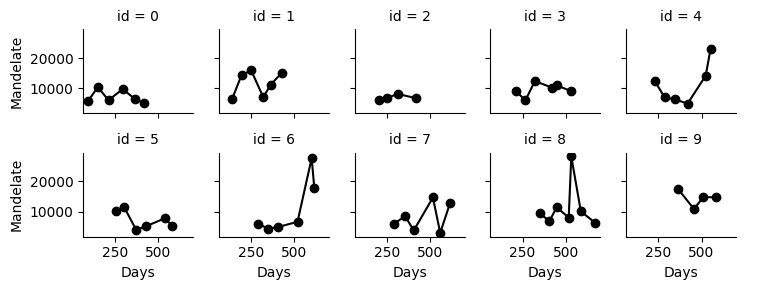

In [33]:
# Show grid of 10 individual examples for a single metabolite
grid = sns.FacetGrid(
        data=(
                mtd_sub[["participant_id", "study_days"]]
                .assign(
                    mandelate = mbx_sub.C18n_QI11.values,
                    id = pd.factorize(mtd_sub["participant_id"])[0]
                )
                .sort_values(by=["participant_id", "study_days"])
                .query("id < 10")
        ), 
        col="id",
        col_wrap=5,
        height=1.5,
)

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "study_days", "mandelate", marker="o", color="black")

# Adjust the tick positions and labels
grid.set(
        xlabel='Days',
        ylabel='Mandelate'
)

# Adjust the arrangement of the plots
grid.figure.tight_layout(w_pad=1.5)

grid.add_legend()


grid.figure.savefig("../../figures/raw_longitudinal_samples.png") 

## Model Search

In [34]:
# Read in older model search or perform search now (uncomment if we want Adam optimizer instead of Scipy LBFGS)
# fp = "./output/fit_penalized_models_adam.pkl"
fp = "./output/fit_penalized_models.pkl"

if os.path.exists(fp):
    print("Reading in saved model object!")
    with open(fp, "rb") as f:
        gps = pickle.load(f)
else:
    # Run quick search
    gps = GPSearch(
        X=mtd_sub,
        Y=mbx_sub,
        unit_col="participant_id",
        categorical_vars=[
            "site_name", "race",
            "sex", "general_wellbeing"
        ],
        outcome_likelihood="negativebinomial",
        Y_transform=None
    )
    gps.penalized_optimization(
        random_seed=9102,
        kernel_options={
            "second_order_numeric": False,
            "unit_numeric_interactions": False,
            "categorical_numeric_interactions": False,
            "kerns": [
                gpflow.kernels.SquaredExponential(),
                Lin(),
            ],
        },
        # optimization_options={
        #     "optimizer": "adam",
        #     "adam_learning_rate": 0.001,
        #     "convergence_threshold": 1e-6
        # }
    )

    # Save modeling object
    with open(fp, "wb") as f:
        pickle.dump(gps, f)

# How many metabolites have we analyzed?
print(f"Number of metabolites analyzed: {len(gps.models)}")

Reading in saved model object!
Number of metabolites analyzed: 564


## Analysis

### Cross-sectional HBI

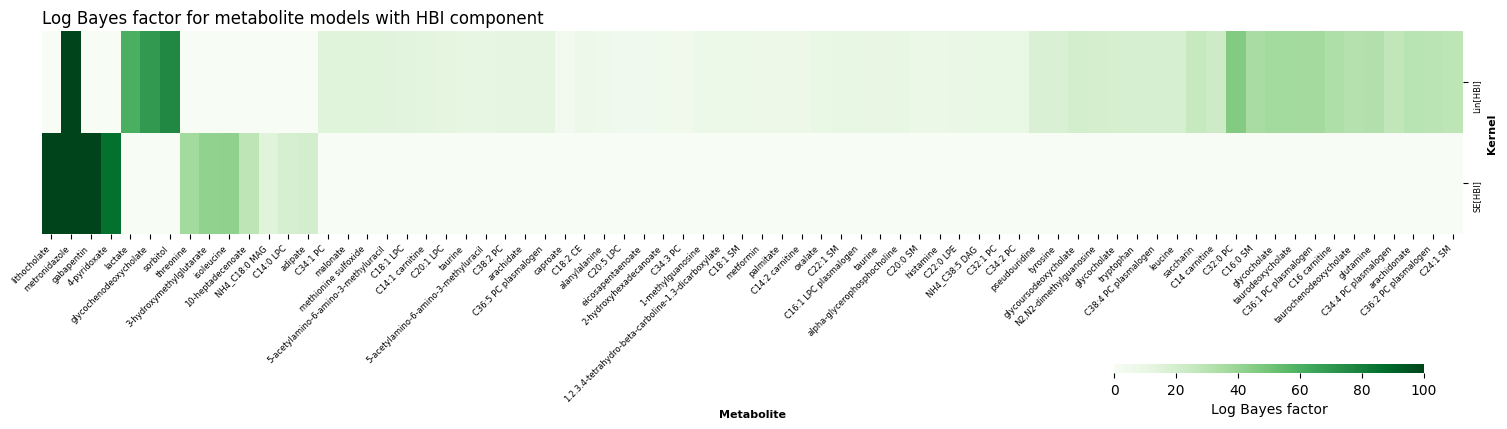

In [35]:
p = gps.plot_heatmap(
    var_cutoff=0,
    feature_name="hbi",
    figsize=(15.5, 3.5),
    cbar_pos=(
        0.75,
        -0.05,
        0.2,
        0.025
    ),
    vmin=0,
    vmax=100,
    show_vals=False,
    yticklabels=["Lin[HBI]", "SE[HBI]"],
    cbar_kws={
        "label": "Log Bayes factor",
        "orientation": "horizontal"
    }
)

# Clean up figure
p.ax_heatmap.set_title("Log Bayes factor for metabolite models with HBI component", loc="left")
p.ax_heatmap.set_xlabel("Metabolite")
p.ax_heatmap.set_ylabel("Kernel")
p.ax_row_dendrogram.set_visible(False)
p.ax_col_dendrogram.set_visible(False)

# Get metabolite name lookup from compound
new_x_ticks = [
    mbx_lookup.loc[mbx_lookup.Compound == y, "Metabolite"].values[0]
    for y in [x.get_text() for x in p.ax_heatmap.get_xticklabels()]
]
p.ax_heatmap.set_xticklabels(
    labels=new_x_ticks
)
p.savefig(fname="../../figures/ihmp_hbi_heatmap.png", dpi=1000)
plt.show()

In [36]:
# Inspect the top metabolites for cross-sectional HBI feature
hbi_compounds = pd.merge(
    left=mbx_lookup,
    right=gps.plot_feature_metrics(
        feature_name="hbi",
        return_df=True,
        top_n=100,
        min_total_explained=0
    ),
    left_on="Compound",
    right_on="name"
).sort_values("metric", ascending=False).reset_index(drop=True)
hbi_compounds

,HMDB (*Representative ID),Metabolite,Compound,name,metric
0,HMDB00761,lithocholate,C18n_QI48,C18n_QI48,122911.9
1,HMDB15052,metronidazole,HILp_QI2850,HILp_QI2850,30553.2
2,HMDB05015,gabapentin,HILp_QI2874,HILp_QI2874,4790.0
3,HMDB00017,4-pyridoxate,HILn_QI18,HILn_QI18,85.7
4,HMDB00247,sorbitol,HILn_QI112,HILn_QI112,75.9
...,...,...,...,...,...
67,HMDB62548,2-hydroxyhexadecanoate,C18n_QI25,C18n_QI25,5.6
68,HMDB08006*,C34:3 PC,C8p_QI23,C8p_QI23,5.4
69,HMDB10397,C20:5 LPC,C8p_QI08,C8p_QI08,5.0
70,HMDB01999,eicosapentaenoate,HILn_QI50,HILn_QI50,4.9


m='lithocholate', c='C18n_QI48'


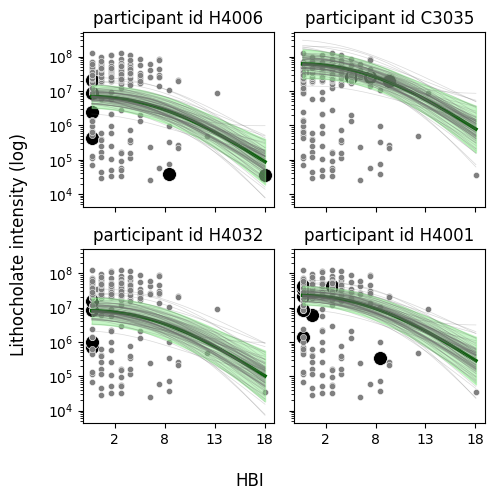

In [37]:
# Plot values for one metabolite (lithocholate) showing changes over HBI
# for four individuals:
#   19 - max HBI
#   13 - highest average HBI
#   27 - lowest average HBI
#   17 - most observations

id_list = [19, 13, 27, 17]
m = "lithocholate"
c = "C18n_QI48"
print(f"{m=}, {c=}")

figs, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(5, 5))
i_list = [0, 1]
j_list = [0, 1]
unit_idx = 0
for i in i_list:
    for j in j_list:
        gps.plot_marginal(
            out_label=c,
            x_axis_label="hbi",
            unit_label=id_list[unit_idx],
            ax=axs[i,j]
        )
        axs[i, j].set_title(f"participant id {gps.categorical_dict['participant_id'][1][id_list[unit_idx]]}")
        axs[i, j].set_xlabel("")
        axs[i, j].set_yscale("log")
        ticks_x = ticker.FuncFormatter(
            lambda x, pos: '{0:n}'.format(
                np.round(x * gps.X_stds["hbi"] + gps.X_means["hbi"])
            )
        )
        axs[i, j].xaxis.set_major_formatter(ticks_x)
        unit_idx+=1

figs.supylabel(f"{m.title()} intensity (log)")
figs.supxlabel("HBI")
figs.tight_layout()
figs.savefig(fname="../../figures/lithocholate_hbi.png", dpi=1000)
plt.show()

### Temporal HBI

In [38]:
# Inspect the top metabolites for time_from_max feature
tfm_compounds = pd.merge(
    left=mbx_lookup,
    right=gps.plot_feature_metrics(
        feature_name="time_from_max",
        return_df=True,
        top_n=50,
        min_total_explained=0 # 0.5
    ),
    left_on="Compound",
    right_on="name",
).sort_values("metric", ascending=False)
tfm_compounds

,HMDB (*Representative ID),Metabolite,Compound,name,metric
7,HMDB02329,oxalate,HILn_TF13,HILn_TF13,47.7
8,HMDB00043,betaine,HILp_QI615,HILp_QI615,30.0
0,HMDB00722,taurolithocholate,C18n_QI60,C18n_QI60,21.2
3,HMDB05456*,C56:6 TAG,C8p_QI201,C8p_QI201,17.5
2,NaN,C42:0 TAG,C8p_QI121,C8p_QI121,17.2
6,HMDB00873,4-methylcatechol,HILn_QI16,HILn_QI16,14.4
4,redundant ion,NH4_C52:6 TAG,C8p_QI171,C8p_QI171,12.5
5,redundant ion,NH4_C52:5 TAG,C8p_QI173,C8p_QI173,9.7
1,HMDB06731,C20:5 CE,C8p_QI76,C8p_QI76,5.9


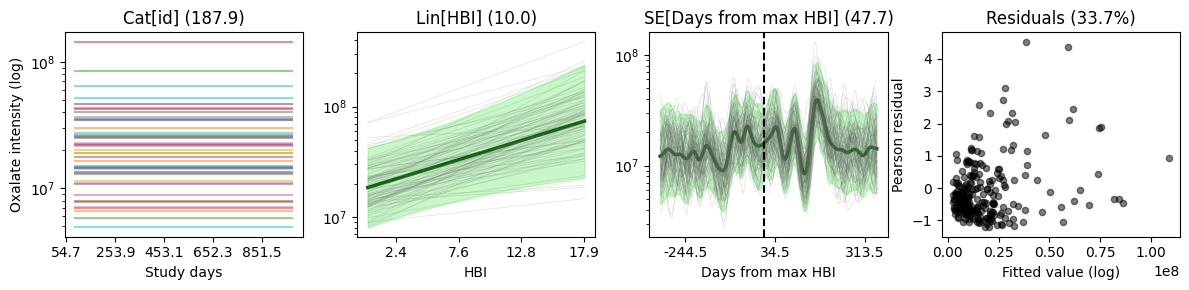

In [39]:
# Clean up plot slightly for paper
p = gps.plot_parts(
    out_label="HILn_TF13",
    x_axis_label="study_days",
    figsize=(12, 3),
    num_cols_in_fig=4,
    reverse_transform_axes=True
)
for i, ax in enumerate(p[1][0]):
    if i == 0:
        ax.set_xlabel("Study days")
        ax.set_ylabel("Oxalate intensity (log)")
        ax.set_title("Cat[id] (187.9)")
    elif i == 1:
        ax.set_xlabel("HBI")
        ax.set_title("Lin[HBI] (10.0)")
    elif i == 2:
        ax.set_xlabel("Days from max HBI")
        ax.set_title("SE[Days from max HBI] (47.7)")
        ax.axvline(
            x=(0 - gps.X_means["time_from_max"]) / gps.X_stds["time_from_max"],
            ls="--",
            c="black"
        )
    else:
        ax.set_xlabel("Fitted value (log)")
        ax.set_ylabel("Pearson residual")
        ax.set_title("Residuals (33.7%)")

    # If not residual plot, then log transform metabolite value
    if i != 3:
        ax.set_yscale("log")

plt.tight_layout()
# figs.savefig(fname="../../figures/oxalate_parts_output.png", dpi=1000)
plt.show()

    HMDB (*Representative ID) Metabolite   Compound
384                 HMDB02329    oxalate  HILn_TF13


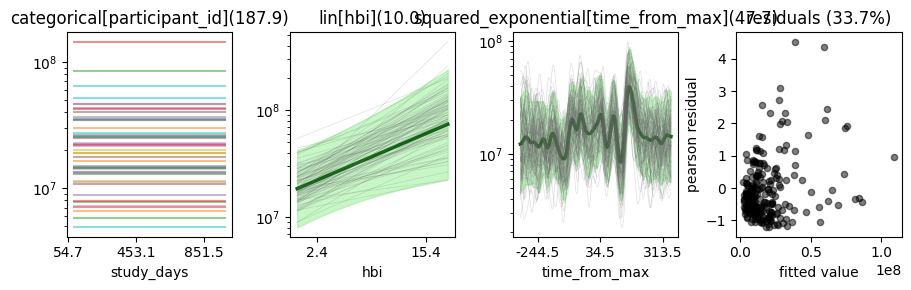

    HMDB (*Representative ID) Metabolite    Compound
458                 HMDB00043    betaine  HILp_QI615


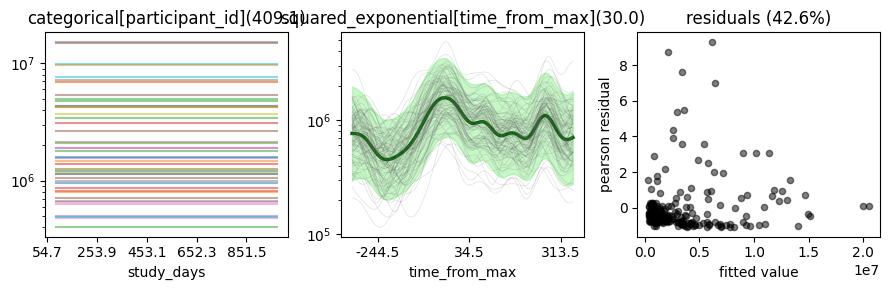

   HMDB (*Representative ID)         Metabolite   Compound
57                 HMDB00722  taurolithocholate  C18n_QI60


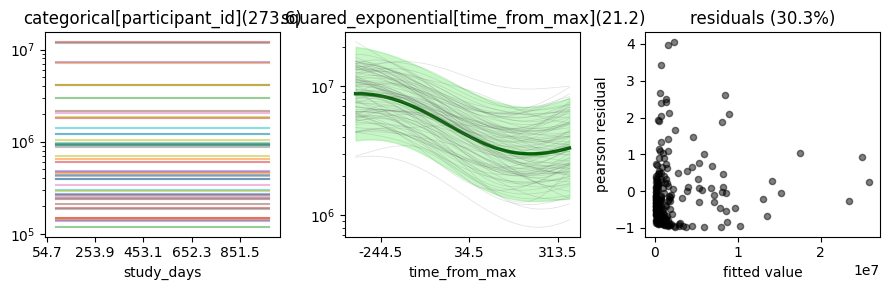

    HMDB (*Representative ID) Metabolite   Compound
224                HMDB05456*  C56:6 TAG  C8p_QI201


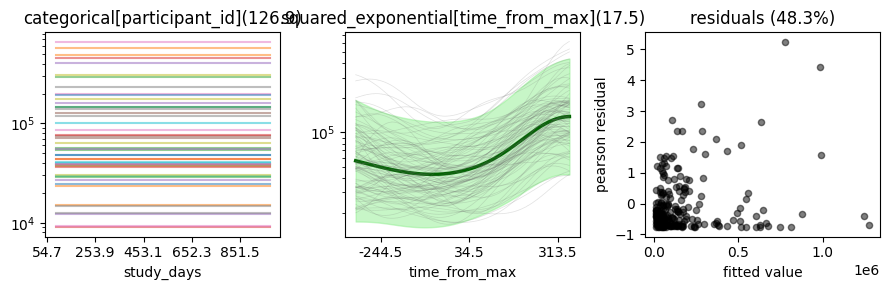

    HMDB (*Representative ID) Metabolite   Compound
182                       NaN  C42:0 TAG  C8p_QI121


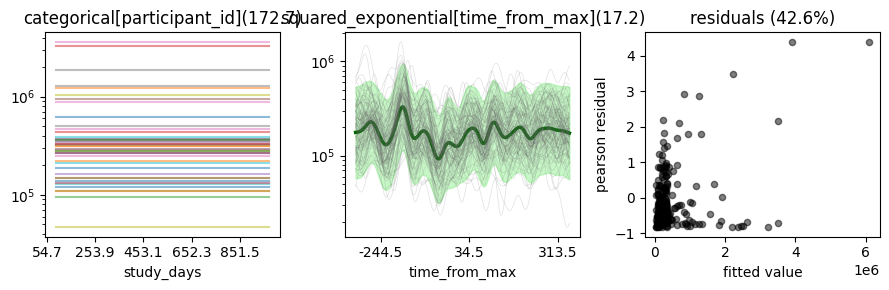

In [ ]:
# Plot parts for compounds of interest (top five metabolites)
for compound_name in tfm_compounds.Compound.iloc[:5]:
    print(mbx_lookup.query(f"Compound == '{compound_name}'"))

    # Get size of kernel
    if hasattr(gps.models[compound_name].kernel, "kernels"):
        kern_len = len(gps.models[compound_name].kernel.kernels)
    else:
        kern_len = 1
    
    # Now plot parts
    p = gps.plot_parts(
        out_label=compound_name,
        x_axis_label="study_days",
        figsize=(9, 3),
        num_cols_in_fig=(kern_len + 1),
        reverse_transform_axes=True
    )

    # Log transform output
    for i, ax in enumerate(p[1][0]):
        if i < (len(p[1][0]) - 1):
            ax.set_yscale("log")
    plt.tight_layout()
    plt.show()